In [89]:
#initial version
#created on 25.11.2020 by kaarel
#Idea to train and predict every SOURCE_KEY separately and build window features
#Inspired by https://www.kaggle.com/furiousx7/xgboost-time-series
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold


train_data = pd.read_csv('../Data/Train_Plant2_added_features.csv')



In [90]:
def create_features(in_data):
    in_data['DATE_TIME'] = pd.to_datetime(in_data['DATE_TIME'])
    in_data["DATE"] = in_data['DATE_TIME'].dt.date
    in_data["HOUR"] = in_data['DATE_TIME'].dt.hour
    in_data["MINUTE"] = in_data['DATE_TIME'].dt.minute
    in_data["DAY_OF_YEAR"] = in_data['DATE_TIME'].dt.dayofyear
    in_data["DAY_OF_WEEK"] = in_data['DATE_TIME'].dt.dayofweek
    in_data["MONTH"] = in_data['DATE_TIME'].dt.month
    in_data["DAY_OF_MONTH"] = in_data['DATE_TIME'].dt.day

In [93]:
#
create_features(train_data)
split_date = pd.to_datetime('06-01-2020')
pred_train = train_data.loc[train_data.DATE <= split_date].copy()
pred_test = train_data.loc[train_data.DATE > split_date].copy()

In [136]:
train_columns = [
       'HOUR',
       'MINUTE',
       'DAY_OF_YEAR',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']


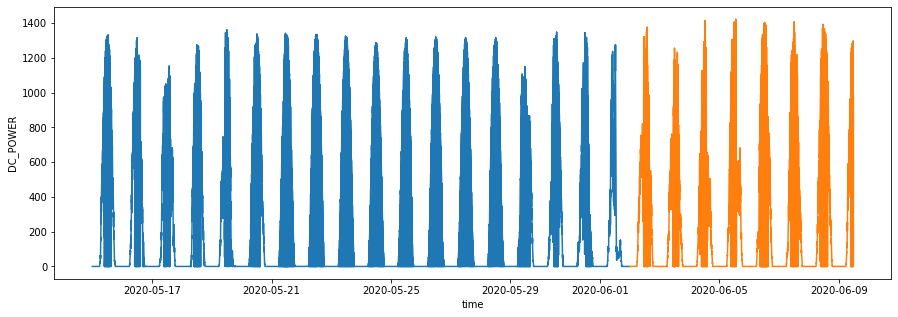

In [140]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(pred_train["DATE_TIME"],pred_train.DC_POWER)
plt.plot(pred_test["DATE_TIME"],pred_test.DC_POWER)
plt.show()

In [141]:
import numpy as np
predict_column = 'DC_POWER'
prediction_models = []
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(pred_train[train_columns], pred_train[predict_column],
        eval_set=[(pred_train[train_columns], pred_train[predict_column]), (pred_test[train_columns], pred_test[predict_column])],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)
prediction_models.append(reg)

[0]	validation_0-rmse:363.31155	validation_1-rmse:372.24383
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:301.83234	validation_1-rmse:337.89243
[2]	validation_0-rmse:265.20303	validation_1-rmse:326.77518
[3]	validation_0-rmse:243.90349	validation_1-rmse:319.76520
[4]	validation_0-rmse:232.00867	validation_1-rmse:312.74225
[5]	validation_0-rmse:220.87204	validation_1-rmse:310.01700
[6]	validation_0-rmse:215.04146	validation_1-rmse:313.78754
[7]	validation_0-rmse:211.73171	validation_1-rmse:317.62524
[8]	validation_0-rmse:207.45558	validation_1-rmse:313.81653
[9]	validation_0-rmse:202.47510	validation_1-rmse:313.31772
[10]	validation_0-rmse:200.27596	validation_1-rmse:313.34415
[11]	validation_0-rmse:197.91540	validation_1-rmse:313.09650
[12]	validation_0-rmse:196.89500	validation_1-rmse:313.31070
[13]	validation_0-rmse:193.08368	validation_1-rmse:313.798

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

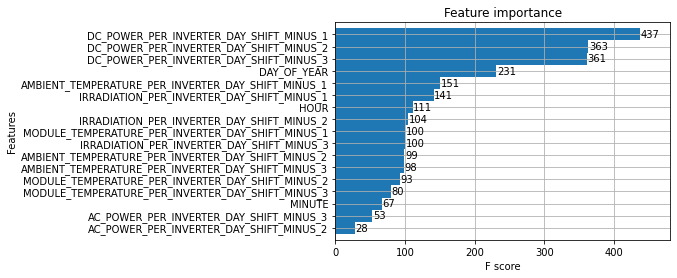

In [139]:
xgb.plot_importance(reg, height=1)

In [126]:
val_predictions = reg.predict(pred_test[train_columns])


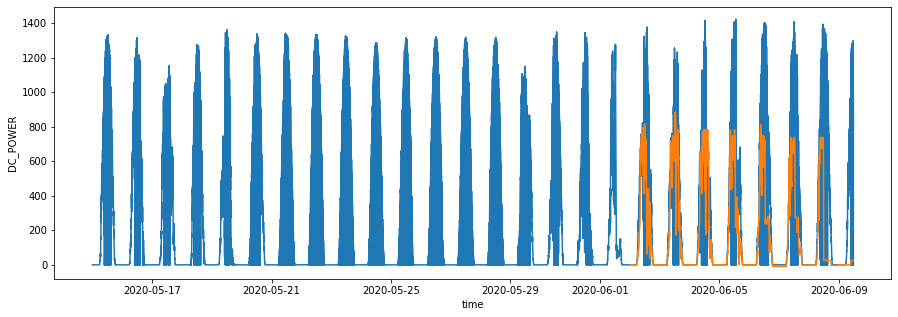

In [142]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(train_data["DATE_TIME"],train_data.DC_POWER)
plt.plot(pred_test["DATE_TIME"],val_predictions)
plt.show()

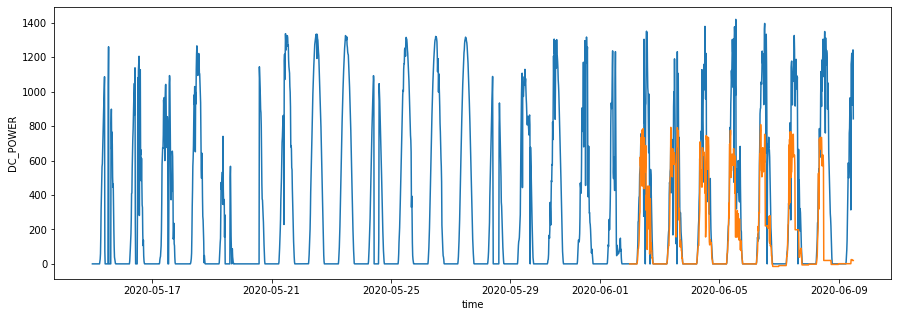

In [143]:

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(train_data[train_data.SOURCE_KEY == '4UPUqMRk7TRMgml']["DATE_TIME"],train_data[train_data.SOURCE_KEY == '4UPUqMRk7TRMgml']["DC_POWER"])
plt.plot(pred_test[pred_test.SOURCE_KEY == '4UPUqMRk7TRMgml']["DATE_TIME"],reg.predict(pred_test[pred_test.SOURCE_KEY == '4UPUqMRk7TRMgml'][train_columns]))
plt.show()
